# CIFAR10 Classification

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Mohammadjavad Maheronnaghsh

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [2]:
import torch
import torchvision
from torchvision import transforms

## Device

Set device to work with (GPU or CPU)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))  # Normalizing
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))  # Normalizing
])

In [6]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [7]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [8]:
train_size = int(0.8 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = torch.utils.data.random_split(initial_trainset, [train_size, val_size])

In [9]:
from torch.utils.data import Subset, DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [10]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

In [10]:
trainset

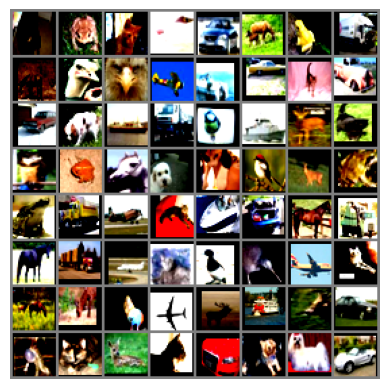

  dog  frog   cat   cat   car horse  frog truck horse  bird  bird plane  ship   car   cat   car   car   dog  ship truck  bird  ship  deer   cat  bird  frog horse   dog   cat  bird  deer  frog  frog truck plane   cat  ship   car horse truck horse truck plane   cat  bird  bird plane   cat horse  deer  bird plane  deer  ship  deer   car  frog   cat  deer   cat   car   dog   dog   car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [11]:
import torch
import torch.nn as nn

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Test the model
model = ResNet18()
print(model)


ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [12]:
net = ResNet18()
net.to(device)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True

In [14]:
# load the model
from google.colab import files
uploaded = files.upload()

Saving model-cifar.pth to model-cifar (1).pth


In [13]:
pth = torch.load('model-cifar (1).pth')
net.load_state_dict(pth)

<All keys matched successfully>

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm
from time import time

In [ ]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_accuracy = 100.0 * correct / total
    return train_loss, train_accuracy
def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_accuracy = 100.0 * correct / total
    return val_loss, val_accuracy


In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

epochs = 50

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, criterion, optimizer, scheduler, trainloader)
    print(f"Epoch [{epoch+1}/{epochs}]: Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    val_loss, val_acc = eval_epoch(net, criterion, valloader)
    print(f"Epoch [{epoch+1}/{epochs}]: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)


Epoch [1/50]: Train Loss: 1.7668, Train Accuracy: 37.44%
Epoch [1/50]: Validation Loss: 1.5558, Validation Accuracy: 45.45%
Epoch [2/50]: Train Loss: 1.4059, Train Accuracy: 50.60%
Epoch [2/50]: Validation Loss: 1.4489, Validation Accuracy: 50.83%
Epoch [3/50]: Train Loss: 1.2170, Train Accuracy: 57.31%
Epoch [3/50]: Validation Loss: 1.1286, Validation Accuracy: 59.79%
Epoch [4/50]: Train Loss: 1.0925, Train Accuracy: 61.97%
Epoch [4/50]: Validation Loss: 1.1218, Validation Accuracy: 60.42%
Epoch [5/50]: Train Loss: 0.9981, Train Accuracy: 65.27%
Epoch [5/50]: Validation Loss: 1.0812, Validation Accuracy: 62.75%
Epoch [6/50]: Train Loss: 0.9486, Train Accuracy: 67.17%
Epoch [6/50]: Validation Loss: 0.9786, Validation Accuracy: 66.61%
Epoch [7/50]: Train Loss: 0.8770, Train Accuracy: 69.58%
Epoch [7/50]: Validation Loss: 0.9512, Validation Accuracy: 67.45%
Epoch [8/50]: Train Loss: 0.8324, Train Accuracy: 71.16%
Epoch [8/50]: Validation Loss: 0.8841, Validation Accuracy: 69.89%
Epoch [9

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

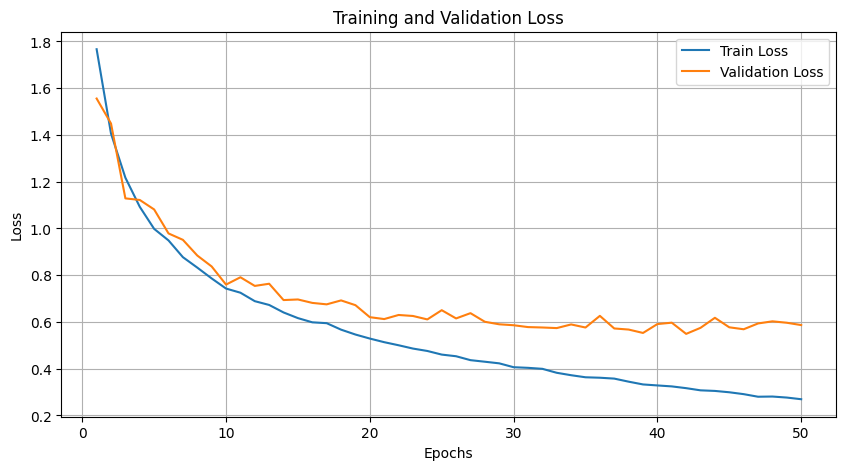

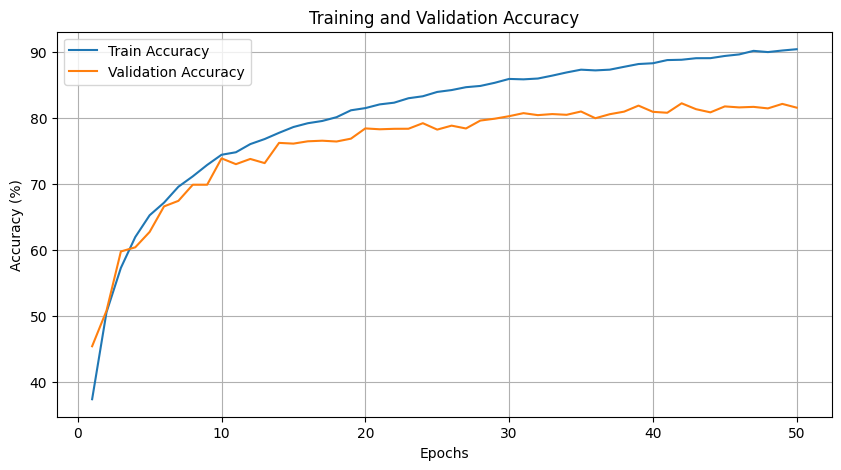

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_list, label='Train Accuracy')
plt.plot(epochs, val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `80%`

In [15]:
def test_model(net, criterion, dataloader):
    net.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(dataloader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

test_model(net, criterion, testloader)

Test Loss: 0.5848, Test Accuracy: 82.39%


In [ ]:
# here i save the model for crashing of colab
from google.colab import files
torch.save(net.state_dict(), 'model.pth')
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load the model
net = ResNet18()
net.to(device)
state_dict = torch.load('model.pth')

net.load_state_dict(state_dict)

## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

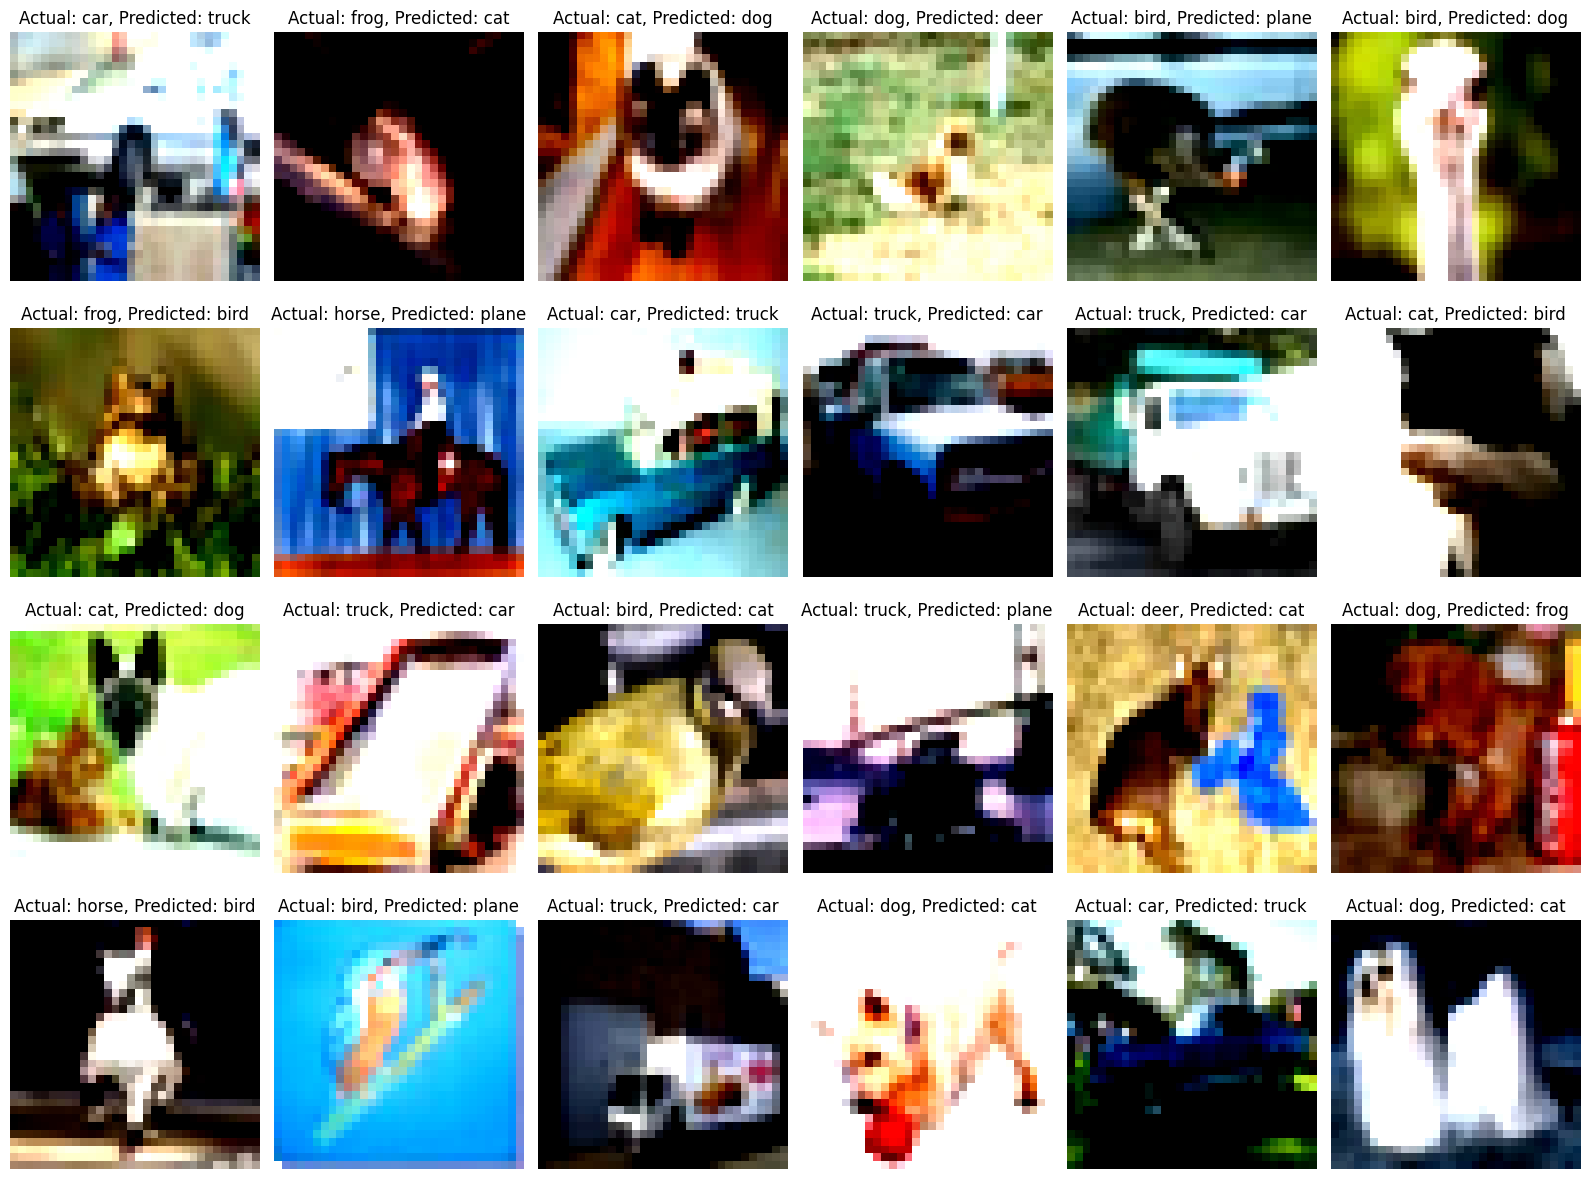

In [ ]:
def visualize_incorrects(net, dataloader):
    net.eval()
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            incorrect_indices = (predicted != labels).nonzero().squeeze()
            if incorrect_indices.ndim == 0:
                incorrect_indices = torch.tensor([incorrect_indices])
            for idx in incorrect_indices:
                incorrect_images.append(images[idx].cpu())
                incorrect_labels.append(labels[idx].cpu())
                incorrect_predictions.append(predicted[idx].cpu())

    num_incorrect = len(incorrect_images)

    indices = np.random.choice(num_incorrect, 24, replace=False)
    fig, axes = plt.subplots(4, 6, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    for i, ax in enumerate(axes.flatten()):
        idx = indices[i]
        img = incorrect_images[idx].permute(1, 2, 0)/2.0+0.5
        label = incorrect_labels[idx]
        prediction = incorrect_predictions[idx]
        img = np.clip(img, 0, 1) # here i normalized the pictures to scale between 0 and 1
        ax.imshow(img)
        ax.set_title(f'Actual: {classes[label]}, Predicted: {classes[prediction]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_incorrects(net, testloader)

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [48]:
def hook_fn(module, input, output):
    global feature_space, idx
    batch_size = output.size(0)
    feature_space[idx: idx + batch_size] = output.view(batch_size, -1)
    idx += batch_size

def hook_fn_new(module, input, output):
    global feature_space, idx
    batch_size = output.size(0)
    feature_space[idx: idx + batch_size] = output.view(batch_size, -1)
    idx += batch_size
def hook_fn_new2(module, input, output):
    global feature_space, idx
    batch_size = output.size(0)
    feature_space.append(input[0])
    idx += batch_size

In [71]:
def calculate_feature_space_new(net, dataloader):
    global feature_space, idx
    net.eval()
    feature_space = []
    labels_ = []
    idx = 0

    hook_handle = net.fc.register_forward_hook(hook_fn_new2)

    with torch.no_grad():
        for images, labels in dataloader:
            idx = 0
            images = images.to(device)
            labels_.append(labels)
            _ = net(images)
    hook_handle.remove()

    return feature_space, labels_

In [99]:
import logging
import contextlib
import io
# logging.disable(logging.CRITICAL)
x, y = calculate_feature_space_new(net, trainloader)
# logging.disable(logging.NOTSET)

In [68]:
# x = torch.stack(train_feature_space, dim=0)
# x = x.reshape(40000, -1)
# print(x.shape)

torch.Size([40000, 1024])


In [ ]:
print('hi')

hi


In [100]:
train_feature_space = torch.cat(x)
labels = torch.cat(y)
print(train_feature_space.shape)
print(labels.shape)

torch.Size([80000, 512])
torch.Size([40000])


In [101]:
train_feature_space2 = train_feature_space[:len(train_feature_space)//2]
print(train_feature_space2.shape)

torch.Size([40000, 512])


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them


**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

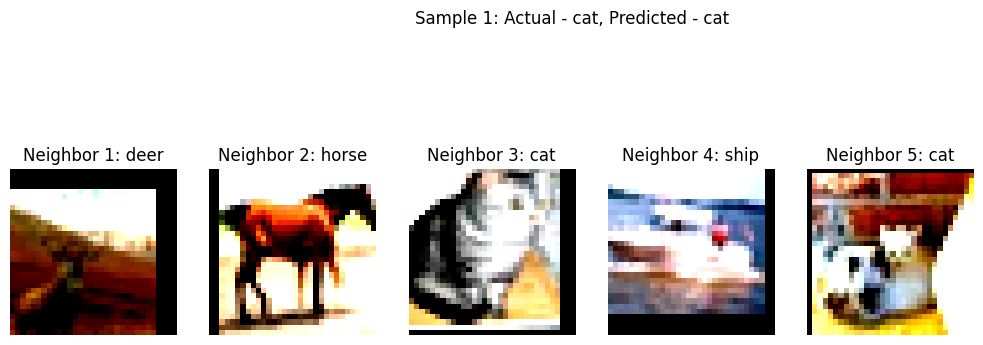

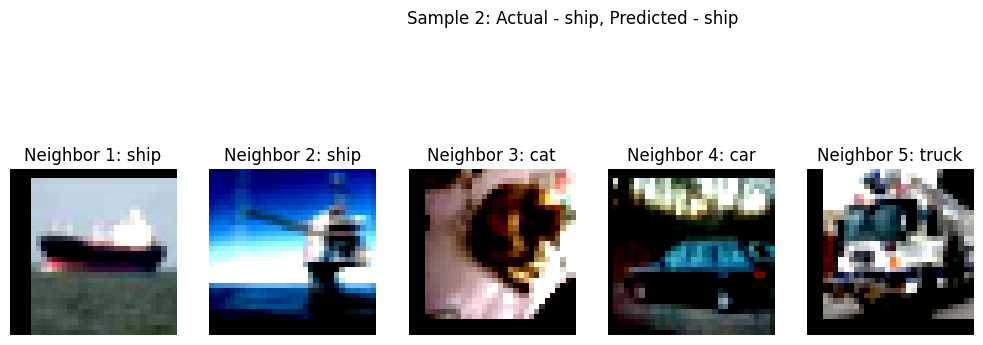

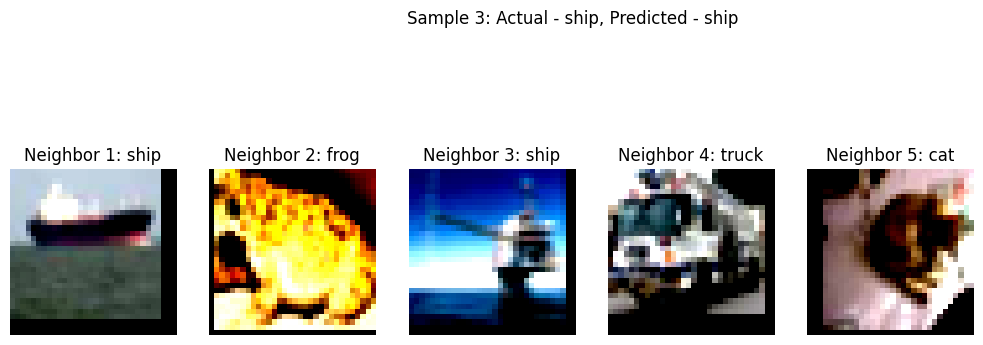

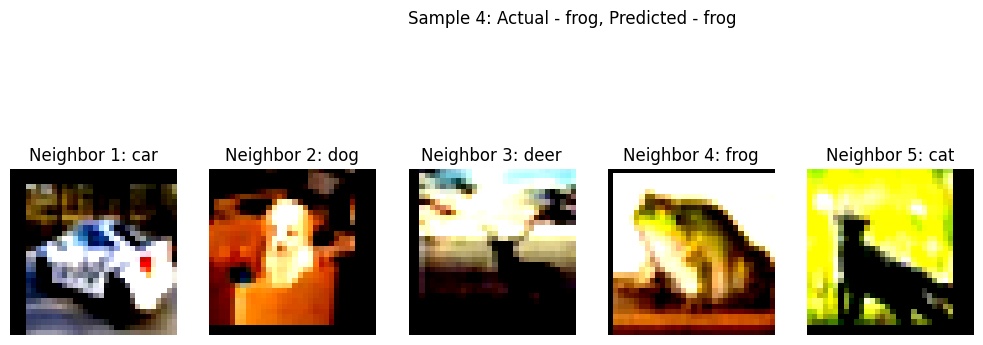

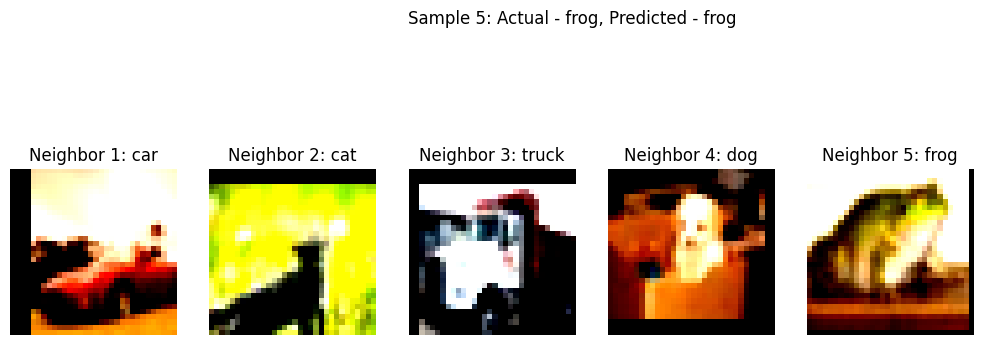

In [20]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Define a function to find nearest neighbors
def find_nearest_neighbors(sample_features, train_features, k=5):
    distances = torch.linalg.norm(train_features - sample_features, dim=1)
    _, nearest_indices = torch.topk(distances, k, largest=False)
    return nearest_indices

correct_samples = []
correct_labels = []
correct_predictions = []

with torch.no_grad(), contextlib.redirect_stdout(io.StringIO()):
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        correct_indices = (predicted == labels).nonzero().squeeze()
        for idx in correct_indices:
            correct_samples.append(images[idx].cpu())
            correct_labels.append(labels[idx].cpu())
            correct_predictions.append(predicted[idx].cpu())
            if len(correct_samples) >= 5:
                break

correct_samples = torch.stack(correct_samples)
correct_labels = torch.tensor(correct_labels)
correct_predictions = torch.tensor(correct_predictions)

with contextlib.redirect_stdout(io.StringIO()):
  correct_sample_features = net(correct_samples.to(device))
train_feature_space = train_feature_space.to(device)

nearest_neighbors_indices = []

for features in correct_sample_features:
    nearest_indices = find_nearest_neighbors(features, train_feature_space)
    nearest_neighbors_indices.append(nearest_indices)
    if len(nearest_neighbors_indices) >= 5:
      break

with contextlib.redirect_stdout(io.StringIO()):
  correct_sample_features = net(correct_samples.to(device))

with contextlib.redirect_stdout(io.StringIO()):
  for i, nearest_indices in enumerate(nearest_neighbors_indices):
      plt.figure(figsize=(15, 5))
      plt.suptitle(f'Sample {i+1}: Actual - {classes[correct_labels[i]]}, Predicted - {classes[correct_predictions[i]]}')
      for j, idx in enumerate(nearest_indices):
          plt.subplot(1, 6, j+1)
          img = trainset[idx][0].permute(1, 2, 0) / 2 + 0.5
          img = np.clip(img, 0, 1)
          plt.imshow(img)
          plt.title(f'Neighbor {j+1}: {classes[trainset[idx][1]]}')
          plt.axis('off')
      plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you have a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Visualize the points in a 2D plane (Set color of each point based on it's class)

**Hint:** You can use `sklearn.manifold.TSNE`

**Hint:** Use `plt.scatter(x, y, c=labels)`


In [21]:
classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [37]:
tsne_features[:, 1].shape
print(np.min(tsne_features[:, 1]))
print(np.max(tsne_features[:, 1]))

-59.12159
183.43068


In [39]:
print(tsne_features[:, 0][1790])
print(np.min(tsne_features[:, 0]))
print(np.max(tsne_features[:, 0]))

-9.318179
-49.157696
184.64088


In [41]:
np.array(subset_labels).shape
print(np.min(subset_labels))
print(np.max(subset_labels))

0
9


In [46]:
unique_elements, counts = np.unique(tsne_features[:, 0], return_counts=True)
unique_elements2, counts = np.unique(tsne_features[:, 1], return_counts=True)

print(unique_elements)
print(unique_elements2)
# Find the repeated numbers
repeated_numbers = unique_elements[counts > 1]

print("Repeated numbers:", repeated_numbers)

[-126.45432   -122.21434    -93.87249    -86.53902    -58.146484
  -25.133831   -22.003721   -21.163406   -18.260132   -17.356638
  -14.742077   -12.410628    -9.492608     0.9339143    2.1735868
   96.1742     119.569565   121.36098  ]
[-76.61603   -74.13197   -52.249325  -47.329567  -21.391586  -17.656107
 -13.834799    1.2355638   1.5058776  15.411111   16.120657   19.019331
  22.532244   24.607632   25.395979   26.163815   34.175575  144.52325  ]
Repeated numbers: [-93.87249  -21.163406 -18.260132 -17.356638]


In [89]:
print(type(labels))
print(labels[0])
print(len(labels))

<class 'torch.Tensor'>
tensor(1)
40000


2000
2000
hi
2000
Number of points plotted: 2000


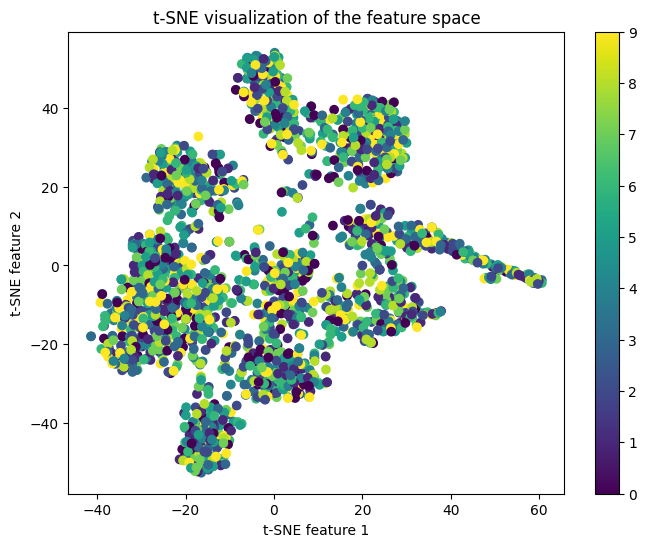

In [102]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

M = 2000
t = train_feature_space[len(train_feature_space)//2:]
random_indices = torch.randperm(len(t))[:M]
random_samples = t[random_indices]

print(len(random_indices))
print(len(random_samples))
random_samples_np = random_samples.detach().cpu().numpy()

# labels2 = torch.tensor(labels)
labels_to_plot = labels[random_indices]
print('hi')
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(random_samples_np)

print(len(tsne_features))

# original_dataset = trainset.dataset
# subset_labels = [original_dataset.targets[idx] for idx in random_indices]

# print(len(subset_labels))

# colormap = plt.cm.tab10
# num_classes = len(classes)
# colors = [colormap(i) for i in np.linspace(0, 1, num_classes)]


plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels_to_plot)
plt.colorbar()
plt.title('t-SNE visualization of the feature space')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

fig = plt.gcf()
ax = plt.gca()
collection = ax.collections[0]
num_points = len(collection.get_offsets())

print("Number of points plotted:", num_points)

plt.show()



# plt.figure(figsize=(10, 8))
# for i in range(len(classes)):  # Assuming there are 10 classes
#     class_indices = [idx for idx, label in zip(random_indices, subset_labels) if label == i and idx < len(tsne_features)]
#     class_tsne_features = tsne_features[class_indices]
#     plt.scatter(class_tsne_features[:, 0], class_tsne_features[:, 1], label=classes[i])

# plt.title('t-SNE Visualization of Feature Space')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend()
# plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [92]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [110]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.cifar10 = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, index):
        rgb_image, _ = self.cifar10[index]
        black_white_image = transforms.Grayscale(num_output_channels=1)(rgb_image)
        # black_white_image = rgb_image.convert('L')

        return black_white_image, rgb_image

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [104]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [105]:
transform_train =transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test =transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [112]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [113]:
train_size = int(0.8 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = torch.utils.data.random_split(initial_trainset, [train_size, val_size])

In [114]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

Black-and-White Image:


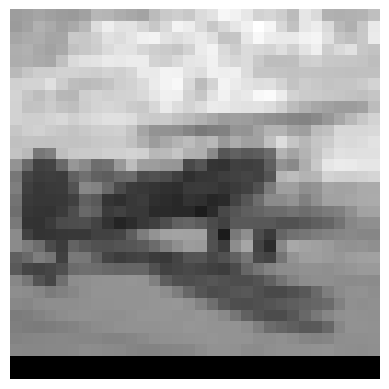

RGB Image:


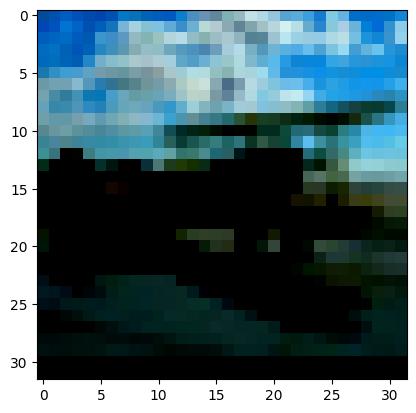

In [128]:
import matplotlib.pyplot as plt

def imshow_gray(img):
    plt.imshow(img.squeeze(), cmap='gray')  # Display as grayscale
    plt.axis('off')
    plt.show()

black_white_image, rgb_image = trainset[0]
print("Black-and-White Image:")
imshow_gray(black_white_image)
print("RGB Image:")
rgb_image = np.transpose(rgb_image, (1, 2, 0))

plt.imshow(rgb_image)

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [209]:

import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransConvBlock, self).__init__()
        self.transconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding = 0),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip_input):
        x = self.transconv(x)
        # print('--')
        # print(x.shape)
        # print(skip_input.shape)
        # print('--')
        x = torch.cat([x, skip_input], dim=1)
        return x

class colorizationNet(nn.Module):
    def __init__(self):
        super(colorizationNet, self).__init__()
        self.down1 = ConvBlock(1, 64)
        self.down2 = ConvBlock(64, 128)
        self.down3 = ConvBlock(128, 256)
        self.down4 = ConvBlock(256, 512)
        self.middle = ConvBlock(512, 1024)
        self.up1 = TransConvBlock(1024, 512)
        self.up2 = TransConvBlock(1024, 256)
        self.up3 = TransConvBlock(512, 128)
        self.up4 = TransConvBlock(256, 64)
        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)

    def forward(self, x):
        conv1 = self.down1(x)
        conv2 = self.down2(nn.functional.max_pool2d(conv1, 2))
        conv3 = self.down3(nn.functional.max_pool2d(conv2, 2))
        conv4 = self.down4(nn.functional.max_pool2d(conv3, 2))
        mid = self.middle(nn.functional.max_pool2d(conv4, 2))
        # print(mid.shape)
        # print(conv4.shape)
        up1 = self.up1(mid, conv4)
        # print(up1.shape)
        # print(conv3.shape)
        up2 = self.up2(up1, conv3)
        up3 = self.up3(up2, conv2)
        up4 = self.up4(up3, conv1)
        return torch.sigmoid(self.final_conv(up4))

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [210]:
net = colorizationNet().to('cuda')

In [ ]:
print(net)

In [159]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [160]:
import tqdm
from time import time

In [213]:
def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader, device='cuda'):
    net.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader.dataset)

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False, device='cuda'):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
    return running_loss / len(dataloader.dataset)

In [215]:
epochs = 20
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for e in range(epochs):
    train_loss = train_epoch(net, criterion, optimizer, trainloader, device)
    val_loss = eval_epoch(net, criterion, valloader, device)
    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# As you can see, it doesnt converge, why? becuase we have to increase the number of
#   epochs in a way that Colab doesnt support
# Please note that for better convergence these steps have to be done:
# 1. add regularizations 2. more epochs 3. more data 4. may be smaller network

cuda
Epoch 1/20, Train Loss: 0.012500003015995026, Val Loss: 0.012533304983377456
Epoch 2/20, Train Loss: 0.012496475347876549, Val Loss: 0.012550247144699097
Epoch 3/20, Train Loss: 0.01250184528529644, Val Loss: 0.012537599384784699
Epoch 4/20, Train Loss: 0.012499186526238918, Val Loss: 0.012540189921855927
Epoch 5/20, Train Loss: 0.012488608561456203, Val Loss: 0.012560133916139603
Epoch 6/20, Train Loss: 0.012493799942731858, Val Loss: 0.012571231758594512
Epoch 7/20, Train Loss: 0.012502916517853737, Val Loss: 0.012563112223148347
Epoch 8/20, Train Loss: 0.012491929970681668, Val Loss: 0.012566232883930207
Epoch 9/20, Train Loss: 0.012485475927591324, Val Loss: 0.012545993769168854
Epoch 10/20, Train Loss: 0.012506911168992519, Val Loss: 0.012593105626106263
Epoch 11/20, Train Loss: 0.012489190398156644, Val Loss: 0.012560136216878891
Epoch 12/20, Train Loss: 0.012493632359802723, Val Loss: 0.01255547935962677
Epoch 13/20, Train Loss: 0.012502562528848647, Val Loss: 0.01255712425

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

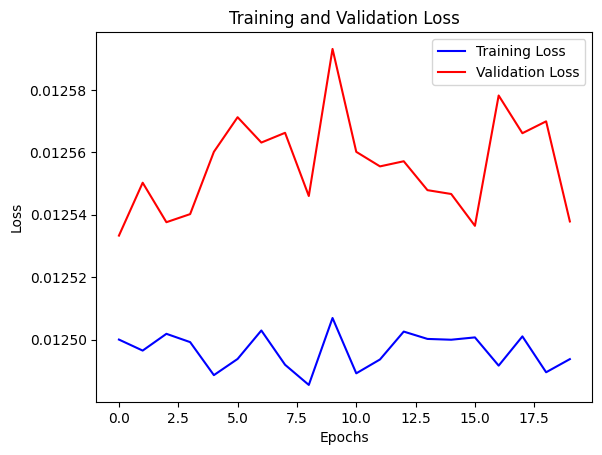

In [217]:
plt.plot([i for i in range(epochs)], train_losses, 'b', label='Training Loss')
plt.plot([i for i in range(epochs)], val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [218]:
testset = BlackAndWhiteCIFAR10(train=False)
testloader = DataLoader(testset, batch_size=1, shuffle=True) # i didnt use it

Files already downloaded and verified


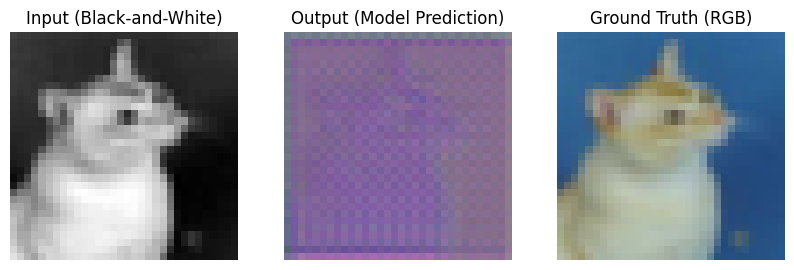

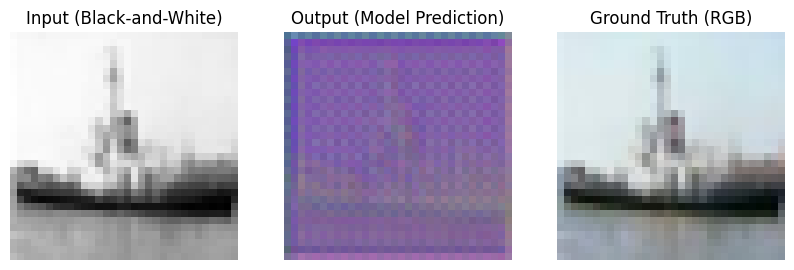

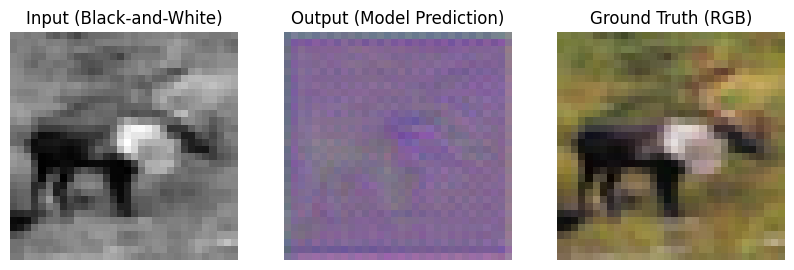

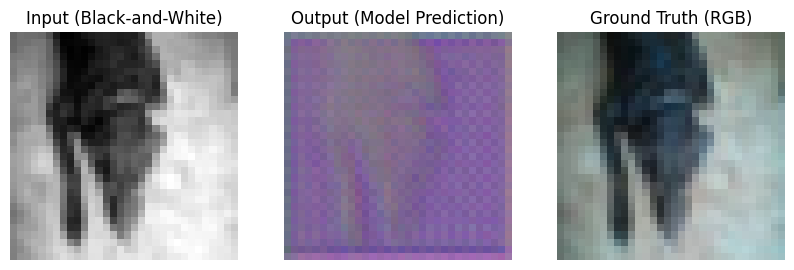

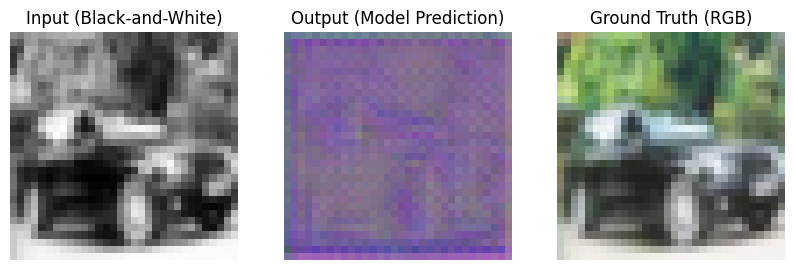

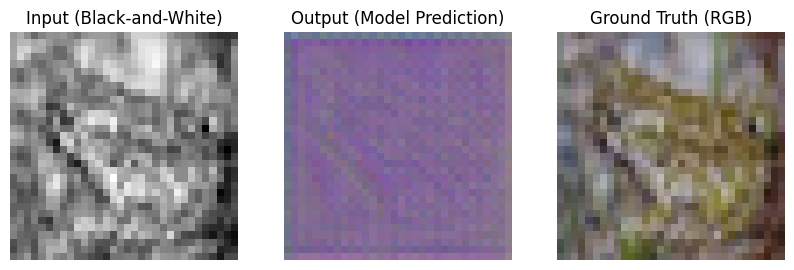

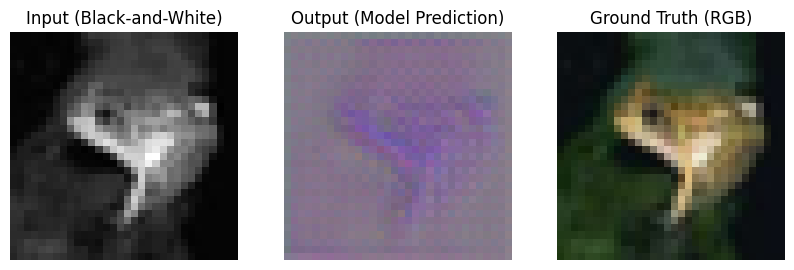

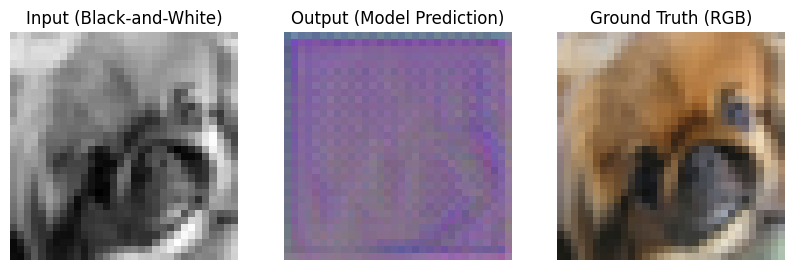

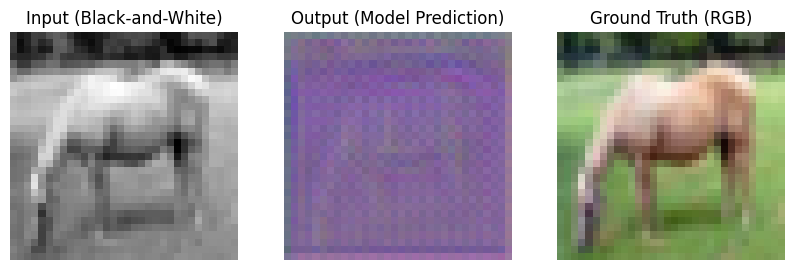

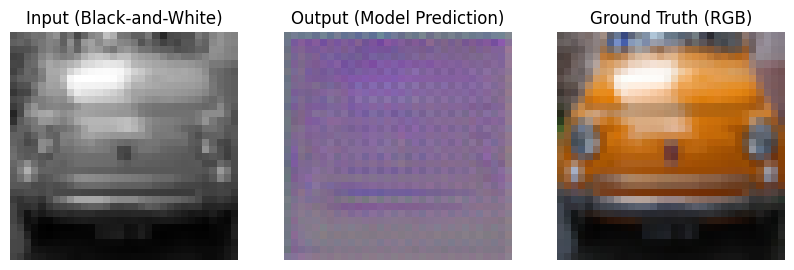

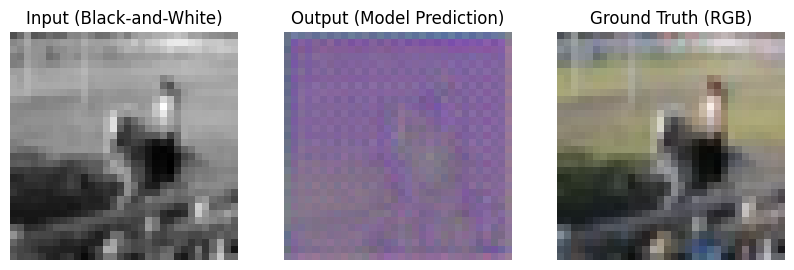

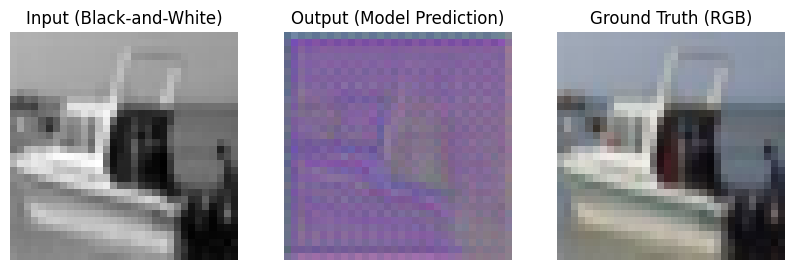

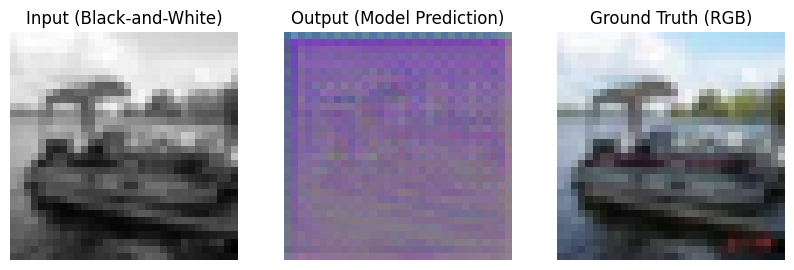

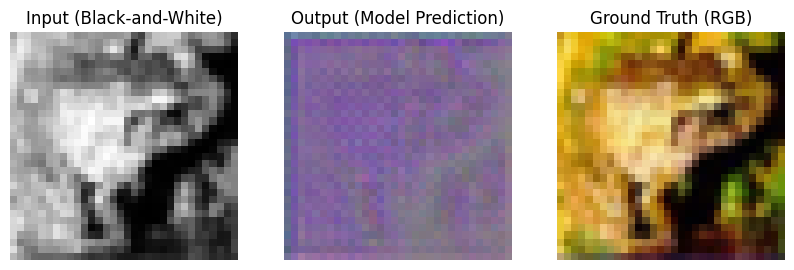

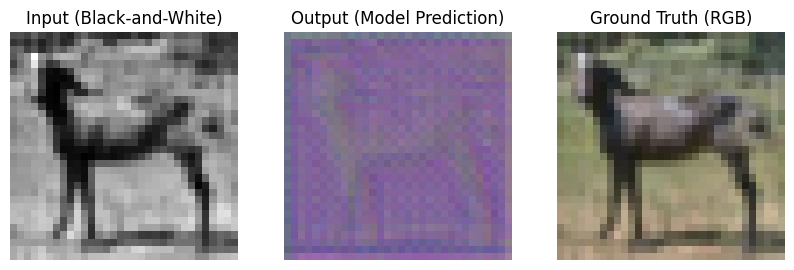

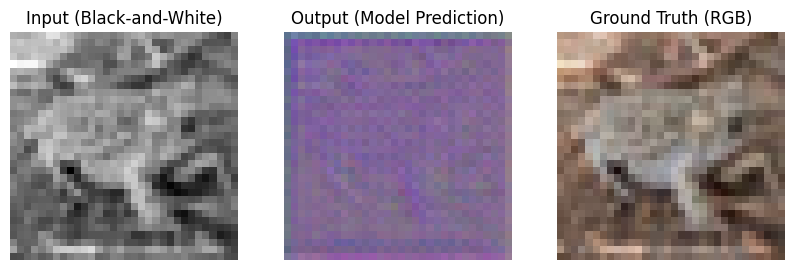

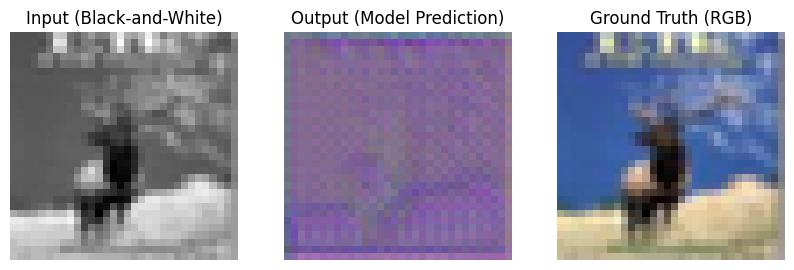

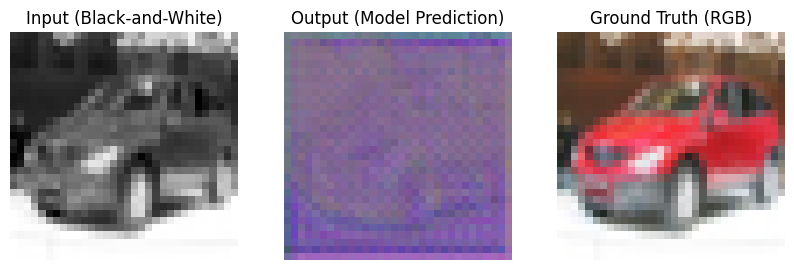

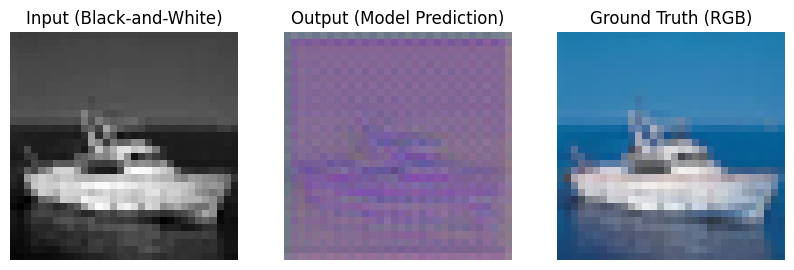

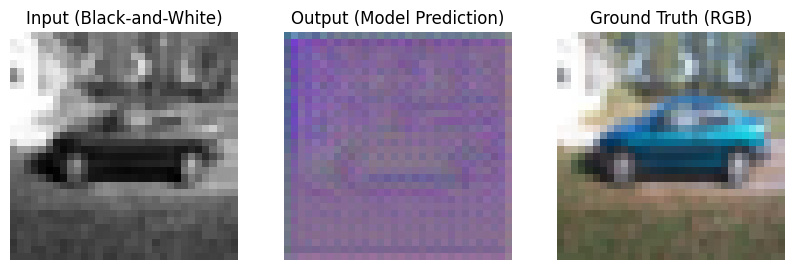

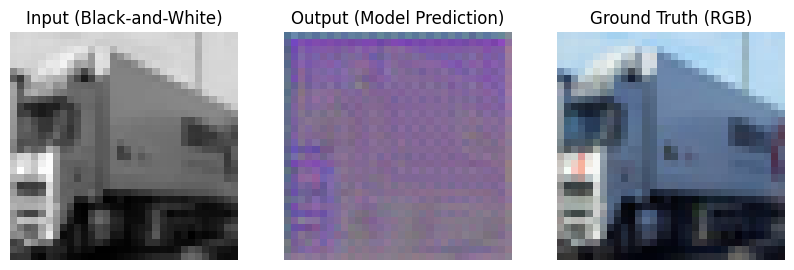

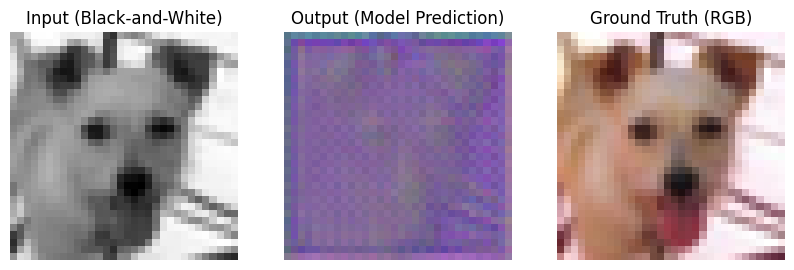

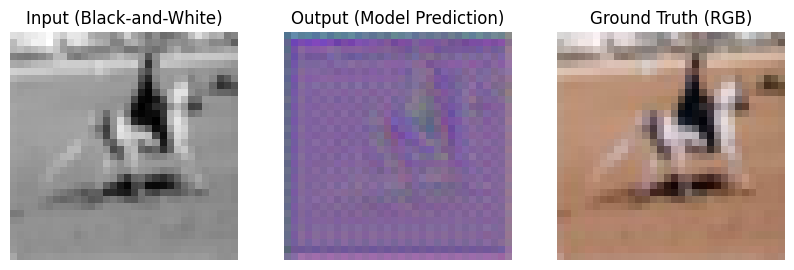

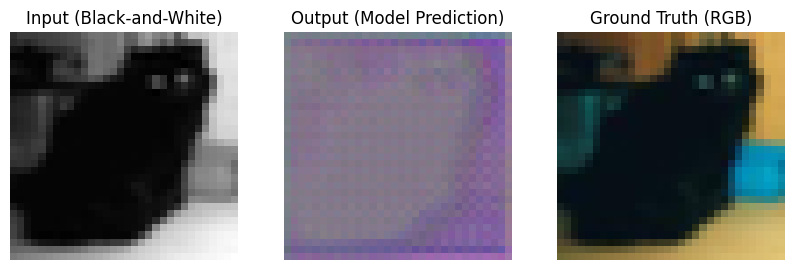

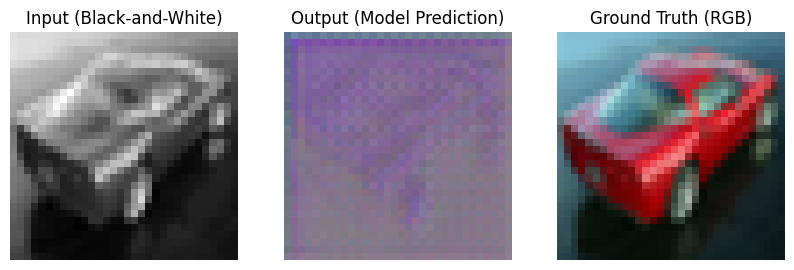

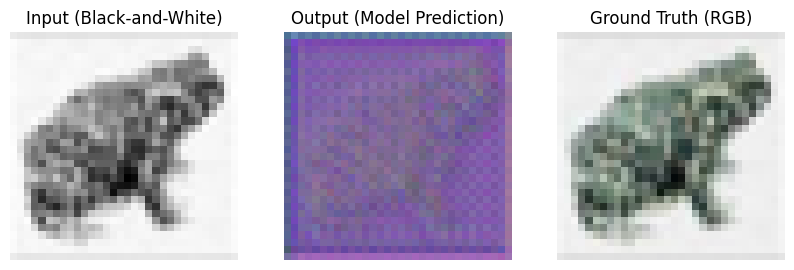

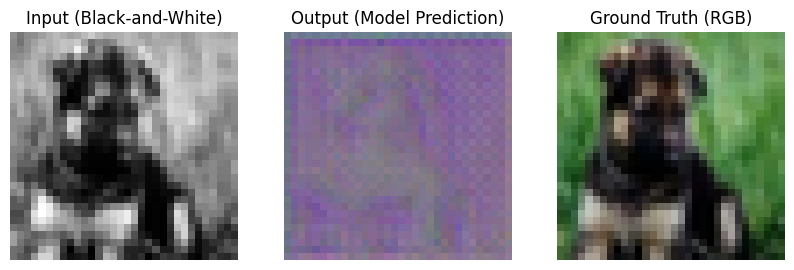

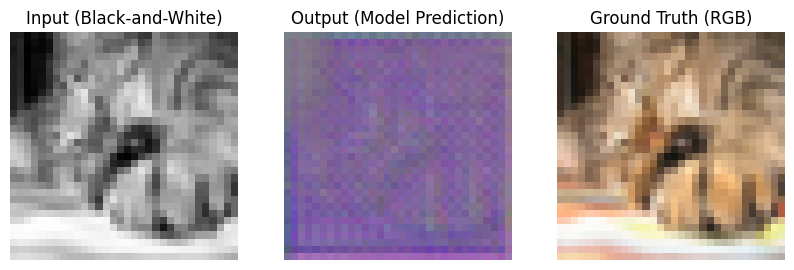

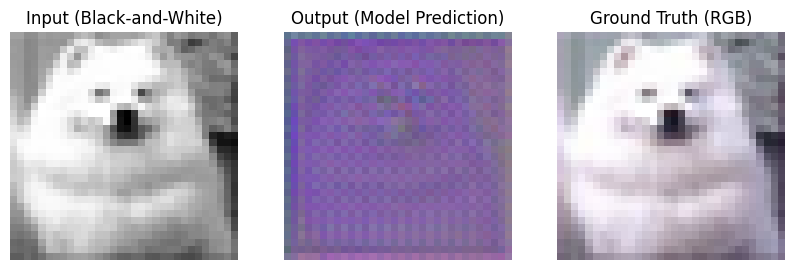

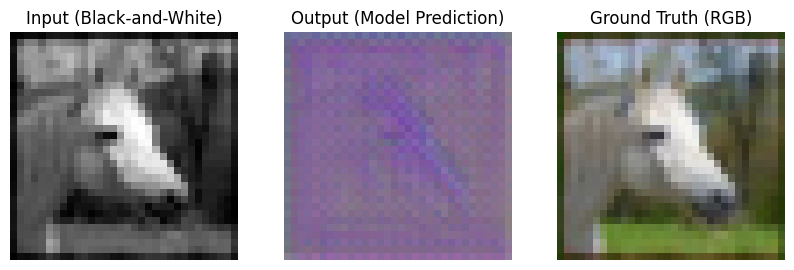

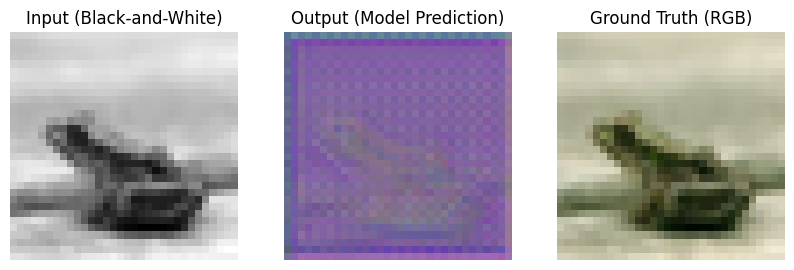

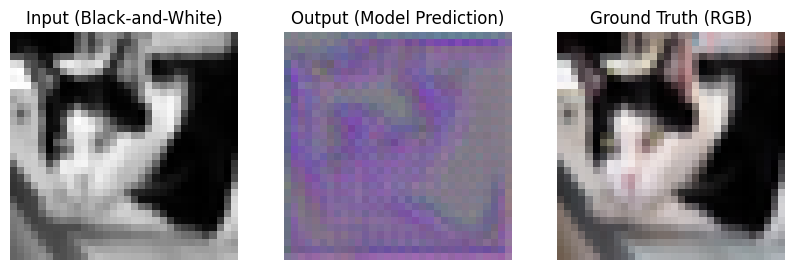

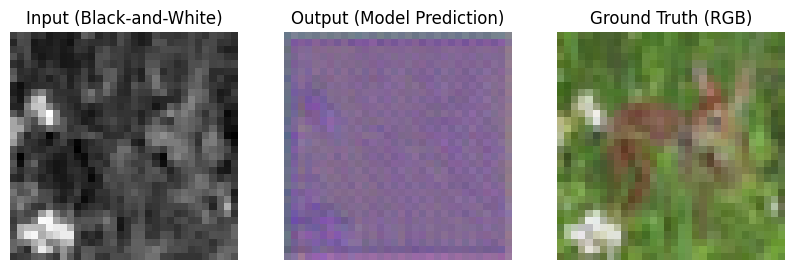

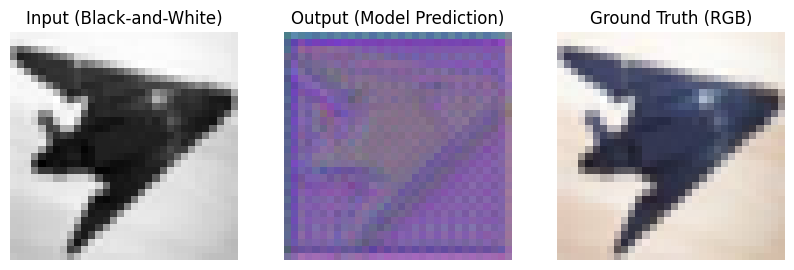

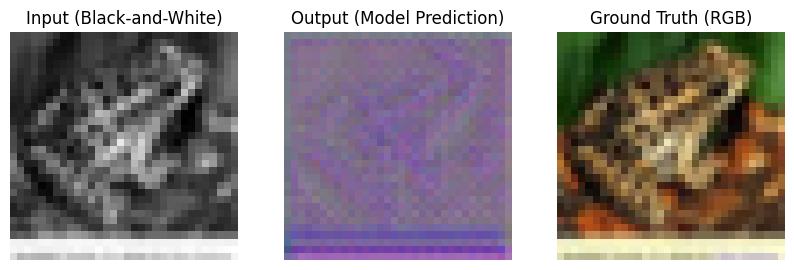

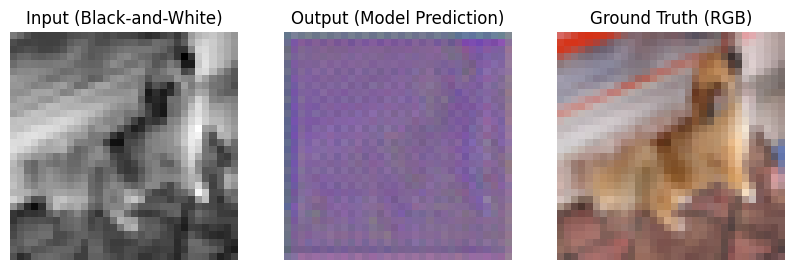

In [241]:
random_indices = np.random.choice(len(testset), 36, replace=False)
for idx in random_indices:
    # input_bw, target_rgb = testset[idx]
    input_bw, target_rgb = testloader.dataset[idx]
    # input_bw = torchvision.transforms.ToTensor()(input_bw)
    # input_bw = input_bw.unsqueeze(0)

    # input_rgb = torchvision.transforms.functional.to_pil_image(input_bw).convert('RGB')
    # input_rgb = torchvision.transforms.functional.to_tensor(input_bw).unsqueeze(0)
    # input_rgb = torchvision.transforms.functional.to_pil_image(input_bw)
    input_bw = torchvision.transforms.ToTensor()(input_bw).unsqueeze(0)

    with torch.no_grad():
        model_output_rgb = net(input_bw.to(device)).squeeze().cpu()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_bw.squeeze(), cmap='gray')
    plt.title('Input (Black-and-White)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(model_output_rgb, (1, 2, 0)))
    plt.title('Output (Model Prediction)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(target_rgb)
    # plt.imshow(np.transpose(target_rgb, (1, 2, 0)))
    plt.title('Ground Truth (RGB)')
    plt.axis('off')

    plt.show()